A workbook illustrating how to use the gp_sandbox functions such as simulating data (random, clustered, candence), sampling the data, and testing multiple input values for parameters of kernels.

In [1]:
%matplotlib notebook
import gp_sandbox as cgp
import pandas as pd
import george
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact

# Simulated Data

In [2]:
def simulated_data_comparison(gamma, period, amp):
    
    x_pos, py, gp1 = cgp.create_data(gamma, period, amp)
    
    def _do_work(n = 10, m = 0, o = 0):
        x, y, yerr = cgp.sample_data(x_pos, py, 1, n, m, o)
    
        gp2, ln_likelihood = cgp.fit_data(x,y,yerr,gamma,period,gp1)
        
        gp3, ln_likelihood_opt, result = cgp.optimize(y, gp2, ln_likelihood, print_results = True)
        
        #ln_prior = cgp.log_prior(gamma, period, amp)
        #ln_post = cgp.log_post(ln_prior, ln_likelihood_opt)
        
        #print("Initial likelihood: " + str(ln_likelihood))
        #print("Optimized likelihood: " + str(ln_likelihood_opt))
        #print("Log prior: " + str(ln_prior))
        #print("Log post: " + str(ln_post))
        
        cgp.plotting(x,y,yerr,py,x_pos,gp2)
        #cgp.plotting(x,y,yerr,py,x_pos,gp3)

    return _do_work

#n will only work if m is set equal to 0

In [3]:
vary_nm = simulated_data_comparison(10,2,2)
interact(vary_nm, n=(0, 100,5), m = (0, 10), o = (0,5), continuous_update=False)

interactive(children=(IntSlider(value=10, description='n', step=5), IntSlider(value=0, description='m', max=10), IntSlider(value=0, description='o', max=5), Output()), _dom_classes=('widget-interact',))

<function __main__.simulated_data_comparison.<locals>._do_work>

# Imported Data
## Asteriod 1291

<IPython.core.display.Javascript object>


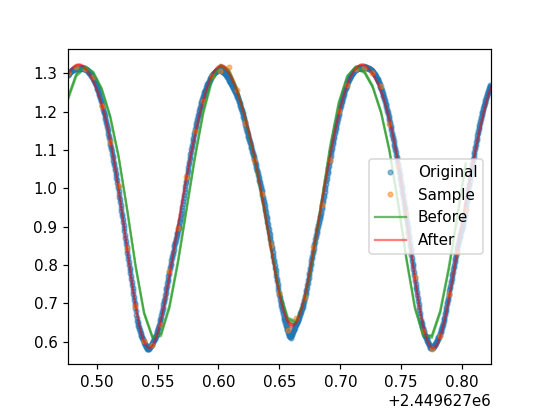

<bound method GP.lnlikelihood of <george.gp.GP object at 0x7f835723ceb8>>       fun: -104.55155847914077
 hess_inv: array([[ 2.89243751e-01, -1.40321163e-01,  1.80163456e-06],
       [-1.40321163e-01,  1.82974313e-01,  2.27990906e-06],
       [ 1.80163456e-06,  2.27990906e-06,  1.24321983e-06]])
      jac: array([ 1.91174217e-06,  2.72963620e-06, -8.75215756e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 68
      nit: 15
     njev: 58
   status: 2
  success: False
        x: array([-0.64939247,  2.28409448, -1.45785386]) 104.55155847914077


In [5]:
#import file into a pandas dataframe
df = pd.read_csv('../data/1291_lc_49627_to_49787.txt', delimiter=' ',header=None, names=['x','y'], dtype={'x':float, 'y':float})
pre_x = (df.x)
pre_y = df.y

cap = 1000

#sample only from the first 2000 points for x and y (out of 400,000ish...)
x, y, yerr = cgp.sample_data(pre_x[0:cap], pre_y[0:cap], 1 , 0, 0, 1)  

#plot the two original points
plt.figure(figsize=(5, 3.75))
plt.plot(pre_x[0:cap], pre_y[0:cap],  '.', alpha=0.5,label="Original")
plt.plot(x,y, '.', alpha=0.5, label="Sample")

#guess the kernel numbers 
kernel = 5*george.kernels.ExpSine2Kernel(gamma=1, log_period=-1.5) #optimal gamma was ~15
gp = george.GP(kernel)
gp.compute(x,yerr)
pred, pred_var = gp.predict(y, x, return_var=True)

#plot the kernel-fitted guess
plt.fill_between(x, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="green", alpha=0.4)
plt.plot(x, pred, lw=1.5, alpha=0.7, label="Before")

#all the x-values visually present we want to map onto
x_short = np.linspace(pre_x[0], pre_x[cap], 1000)

#optimize the fit
gp2, ln_like2, result = cgp.optimize(y,gp,gp.lnlikelihood, print_results=True)
pred, pred_var = gp2.predict(y, x_short, return_var=True)

#print the optimized fit
plt.fill_between(x_short, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="red", alpha=0.4)
plt.plot(x_short, pred, "red", lw=1.5, alpha=0.5, label="After")
plt.xlim([pre_x[0], pre_x[cap]])
plt.legend()

## Asteriod 3200

<IPython.core.display.Javascript object>


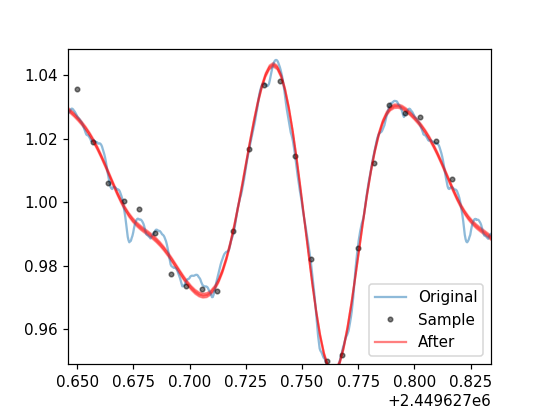

<bound method GP.lnlikelihood of <george.gp.GP object at 0x7f8357188b70>>       fun: -333.2318337106168
 hess_inv: array([[ 3.20916463e-01, -6.24898500e-02,  6.94508816e-07],
       [-6.24898500e-02,  4.63440847e-02,  3.81982995e-07],
       [ 6.94508816e-07,  3.81982995e-07,  2.42700645e-08]])
      jac: array([-4.49359504e-07,  3.79295204e-06, -3.77957150e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 142
      nit: 15
     njev: 123
   status: 2
  success: False
        x: array([-1.24636103,  0.95402717, -1.89612476]) 333.2318337106168


In [7]:
#import file into a pandas dataframe
df = pd.read_csv('../data/3200_lc_49627_to_49787.txt', delimiter=' ',header=None, names=['x','y'], dtype={'x':float, 'y':float})
pre_x = df.x
pre_y = df.y

cap = 5000

#sample only from the first 2000 points for x and y (out of 400,000ish...)
x, y, yerr = cgp.sample_data(pre_x[0:cap], pre_y[0:cap], 0.2 , 0, 0, 2)  

#plot the two original points
plt.figure(figsize=(5, 3.75))
plt.plot(pre_x[0:cap], pre_y[0:cap],  '-', alpha=0.5, label="Original")
plt.plot(x,y, 'ko', ms = 3, alpha=0.5, label="Sample")

#guess the kernel numbers 
kernel = 0.5*george.kernels.ExpSine2Kernel(gamma=1, log_period=-1.8) #optimal gamma was ~15
gp = george.GP(kernel)
gp.compute(x,yerr)
pred, pred_var = gp.predict(y, x, return_var=True)

#plot the kernel-fitted guess
#plt.fill_between(x, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="green", alpha=0.4)
#plt.plot(x, pred, lw=1.5, alpha=0.7, label="Before")

#all the x-values visually present we want to map onto
x_short = np.linspace(pre_x[0], pre_x[cap], 1000)

#optimize the fit
gp2, ln_like2, result = cgp.optimize(y,gp,gp.lnlikelihood, print_results=True)
pred, pred_var = gp2.predict(y, x_short, return_var=True)

#print the optimized fit
plt.fill_between(x_short, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="red", alpha=0.4)
plt.plot(x_short, pred, "red", lw=1.5, alpha=0.5, label="After")
plt.xlim([pre_x[0], pre_x[cap]])
plt.legend()


In [26]:
gp.get_parameter_names()

('kernel:k1:log_constant', 'kernel:k2:gamma', 'kernel:k2:log_period')

# Parameter Study

In [46]:
parameter = np.zeros(len(fun_values))
function_value = np.zeros(len(fun_values))

In [19]:
def fun_generator(amp, gamma, log_period):
    #guess the kernel numbers 
    kernel = amp*george.kernels.ExpSine2Kernel(gamma=gamma, log_period=log_period) #optimal gamma was ~15
    gp = george.GP(kernel)
    
    gp.compute(x,yerr)
    return gp.lnlikelihood(y)
    #pred, pred_var = gp.predict(y, x, return_var=True)

    #optimize the fit
    #gp2, ln_like2, fun = cgp.optimize(y,gp,gp.lnlikelihood, print_results=False)
    #return fun

In [20]:
#import file into a pandas dataframe
df = pd.read_csv('3200_lc_49627_to_49787.txt', delimiter=' ',header=None, names=['x','y'], dtype={'x':float, 'y':float})
pre_x = df.x
pre_y = df.y
#sample only from the first 2000 points for x and y (out of 400,000ish...)
x, y, yerr = cgp.sample_data(pre_x[0:2000], pre_y[0:2000], 0.2, int(0.1*len(pre_x[0:2000])), 0, 0)  

### Period

In [21]:
periods = np.zeros((12,2))

for i in np.arange(len(periods)):
    periods[i][0] = 2*(i+1)
    periods[i][1] = np.log(2.0*(i+1)/24)

fun_values = np.zeros((len(periods),2))

for i in np.arange(len(periods)):
    fun_values[i][0] = periods[i][0]
    #fun_values[i][1] = periods[i][1]
    #print(periods[i][1])
    fun_values[i][1] = fun_generator(1,1,periods[i][1])
    
print(fun_values)

[[  2.00000000e+00  -3.44373335e+05]
 [  4.00000000e+00  -2.58585474e+05]
 [  6.00000000e+00  -1.99958722e+05]
 [  8.00000000e+00  -2.52080959e+05]
 [  1.00000000e+01  -2.24751343e+05]
 [  1.20000000e+01  -2.35996987e+05]
 [  1.40000000e+01  -1.86713844e+05]
 [  1.60000000e+01  -1.98529430e+05]
 [  1.80000000e+01  -1.75020240e+05]
 [  2.00000000e+01  -1.73282583e+05]
 [  2.20000000e+01  -1.79805146e+05]
 [  2.40000000e+01  -1.95610281e+05]]


### Gamma

In [53]:
gamma = np.zeros(12)

for i in np.arange(len(gamma)):
    gamma[i] = i+1

fun_values = np.zeros((len(gamma),2))

for i in np.arange(len(gamma)):
    fun_values[i][0] = gamma[i]
    fun_values[i][1] = fun_generator(1,gamma[i], -1.09861229e+00)
    
print(fun_values)

[[   1.          437.00627761]
 [   2.         -214.46392202]
 [   3.         -277.80597729]
 [   4.         -277.80597729]
 [   5.          669.76129127]
 [   6.          457.60034355]
 [   7.         -214.46392202]
 [   8.         -277.80597729]
 [   9.         -214.46392202]
 [  10.         -214.46392202]
 [  11.         -214.02884292]
 [  12.         -214.46392202]]


### Amplitude

In [59]:
amp = np.zeros(12)

for i in np.arange(len(amp)):
    amp[i] = i+1

fun_values = np.zeros((len(amp),2))

for i in np.arange(len(amp)):
    fun_values[i][0] = amp[i]
    fun_values[i][1] = fun_generator(amp[i], 1, -1.09861229e+00)
    
print(fun_values)

[[  1.00000000e+00  -2.30721692e+02]
 [  2.00000000e+00   6.68589778e+02]
 [  3.00000000e+00   8.04568583e+04]
 [  4.00000000e+00  -2.46101340e+02]
 [  5.00000000e+00   6.56061666e+04]
 [  6.00000000e+00   6.35488700e+04]
 [  7.00000000e+00  -2.72942695e+02]
 [  8.00000000e+00   1.76632777e+04]
 [  9.00000000e+00   9.51881769e+02]
 [  1.00000000e+01   6.11017824e+02]
 [  1.10000000e+01   5.46198417e+02]
 [  1.20000000e+01   3.38505396e+02]]


### Plotting

In [29]:
for i in np.arange(len(fun_values)):
    parameter[i] = fun_values[i][0]
    function_value[i] = fun_values[i][1]

<IPython.core.display.Javascript object>


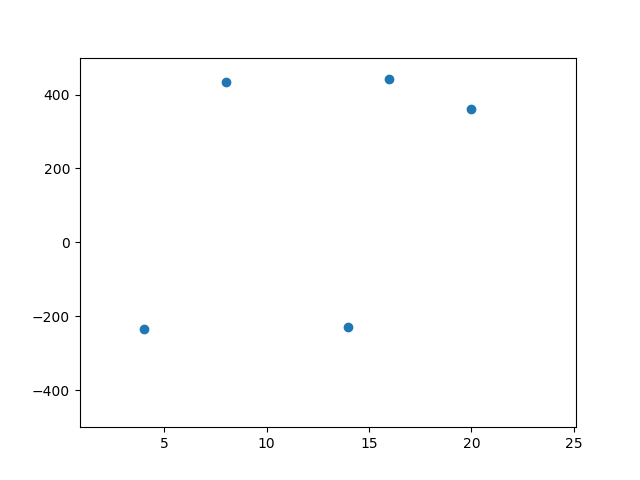

(-500, 500)

In [32]:
plt.figure()
plt.plot(parameter, function_value, 'o')
plt.ylim([-500,500])

## To Do

add more data and sample more sparsely 
test sampling with m parameter
make yerr an input (1%)
look at emcee documentation
make parameter graphs

definition - gamma: length scale of variation

### parameter graphs

* amp, gamma, period = 5-10 each
* P = (1-24 hrs)
* 3 separate plots of parameter vs fun output (get from looping)


### cadence 
1 pt every 10 minutes of 8 hrs per night

2/4 nights per month (consecutive for 6/2 months)

In [7]:
cgp.cadence_set(pre_y, 5)

460830
[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420, 3440, 3460, 3480, 3500, 3520, 3540, 3560, 3580, 3600, 3620, 3640, 3660, 3680, 3700, 3720, 3740, 3760, 3780, 3800, 3820, 5760, 5780, 5800, 5820, 5840, 5860, 5880, 5900, 5920, 5940, 5960, 5980, 6000, 6020, 6040, 6060, 6080, 6100, 6120, 6140, 6160, 6180, 6200, 6220, 6240, 6260, 6280, 6300, 6320, 6340, 6360, 6380, 6400, 6420, 6440, 6460, 6480, 6500, 6520, 6540, 6560, 6580, 6600, 6620, 6640, 6660, 6680, 6700, 8640, 8660, 8680, 8700, 8720, 8740, 8760, 8780, 8800, 8820, 8840, 8860, 8880, 8900, 8920, 8940, 8960, 8980, 9000, 9020, 9040, 9060, 9080, 9100, 9120, 9140, 9160, 9180, 9200, 9220, 92